In [118]:
import glob
import random
import re
import nltk
nltk.download('stopwords')
!pip3 install stemming
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string

# Spectral clustering
import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn import cluster
import networkx as nx
import scipy
from scipy.sparse.linalg import eigs, eigsh
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt

# Community detection
import json

# Sentiment Analysis 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.8)
import collections

/Users/jiayizhang/.zshenv:2: command not found: rbenv


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiayizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read Music CDs customer review file
df = pd.read_json("Movies_and_TV.json", lines=True)

# Get the size of the dataset
len(df)

16010

In [3]:
# Generate English stopwords
sws = set(stopwords.words('english'))

In [83]:
# Video related stopwords and words that are frequent in reivews but generally not helpful for sentiment analysis 
topic_related_sws = {"version", "action", "dvd", "classic", "story", "character", "film", "films", "watch", "movie", "tv", "could", "would", "get", "one", "new", "old", "still", 
                     "back", "even", "also", "culture", "many", "years","cinema","feature","drama",
                    "screenplay","animation","movies","screenplay","cartoon","thriller", "DVD", "Blu-ray",
                    "Streaming", "HD", "4K", "Soundtrack", "Subtitles", "Aspect ratio", "Plot", "Characters",
                    "Special effects", "Cinematography", "Editing", "Dialogue", "Screenplay", "Genre", "Sequel",
                    "Prequel", "Remake", "Adaptation", "Director", "Actor", "Actress", "Supporting cast", 
                    "Running time", "Bonus features", "Extras", "Collector's edition", "Limited edition", "Digital copy"}

In [84]:
# Get all review text
all_docs = df['reviewText'].values

In [85]:
# Sentiment Analysis
# Remove English stopwords, words of insig length, and links
sid = SentimentIntensityAnalyzer()
exclude = set(string.punctuation)
review = []
scores = []

for n, doc in enumerate(all_docs):
    tokens = nltk.word_tokenize(str(doc).lower())
    parsed_tokens = [i for i in tokens 
                        if i not in sws   # drop stopwords 
                             and len(i) > 2  # drop words of insig length
                             and (not i.startswith("http")) # drop links
                             and i not in exclude # drop punctuations
                             and i not in topic_related_sws] #drop music related stopwords
    parsed_sentence = ' '.join(parsed_tokens)
    review += [parsed_sentence]
#     print('SENTENCE {} WITHOUT STOPWORDS: {}'.format(n, parsed_sentence))

    data = sid.polarity_scores(parsed_sentence)
#     for k in sorted(data):
#         print('{0}: {1}, '.format(k, data[k]), end='')
#     print()
    
    data['review'] = parsed_sentence
    scores += [data]

In [86]:
len(scores)

16010

In [87]:
# Create data frame
dataFrame = pd.DataFrame(scores)

# Create data frame with label
def label_sentiment(row):
    cutoff = .5
    if row.compound < -1 * cutoff:
        return "neg"
    elif row.compound > cutoff:
        return "pos"
    else:
        return "neu"
    

dataFrame["label"] = dataFrame.apply(label_sentiment, axis=1)
dataFrame.head()

,neg,neu,pos,compound,review,label
0,0.039,0.537,0.424,0.9312,sorry n't purchase ago first came good enterta...,pos
1,0.000,0.631,0.369,0.8221,believe tell receive blessing watching video c...,pos
2,0.000,0.647,0.353,0.8540,seen live times early days recent reunion show...,pos
3,0.019,0.554,0.427,0.9902,excited finally live concert video 've seen tw...,pos
4,0.037,0.740,0.223,0.9920,best punk bands ever n't like calling punk ban...,pos


In [88]:
avg_sentiment_score = sum(dataFrame['compound'])/len(dataFrame['compound'])
print("The average sentiment score is ", round(avg_sentiment_score,2))

The average sentiment score is  0.54


In [89]:
pos = dataFrame[dataFrame.label=="pos"]
len(pos)

10863

In [90]:
neg = dataFrame[dataFrame.label=="neg"]
len(neg)

1171

In [91]:
neu = dataFrame[dataFrame.label=="neu"]
len(neu)

3976

In [92]:
pos_percentage = len(pos) / len(scores)
print("% of positive review is ", round(pos_percentage,2))

% of positive review is  0.68


In [93]:
neg_percentage = len(neg) / len(scores)
print("% of negative review is ", round(neg_percentage,2))

% of negative review is  0.07


In [94]:
neu_percentage = len(neu) / len(scores)
print("% of neutral review is ", round(neu_percentage,2))

% of neutral review is  0.25


In [95]:
positive_scores_sum = sum(dataFrame[dataFrame.label=="pos"].compound)
print("The average positive score is ", round(positive_scores_sum/len(pos),2))

The average positive score is  0.83


In [96]:
negative_scores_sum = sum(dataFrame[dataFrame.label=="neg"].compound)
print("The average negative score is ", round(negative_scores_sum/len(neg),2))

The average negative score is  -0.82


In [97]:
neutral_scores_sum = sum(dataFrame[dataFrame.label=="neu"].compound)
print("The average neutral score is ", round(neutral_scores_sum/len(neu),2))

The average neutral score is  0.15


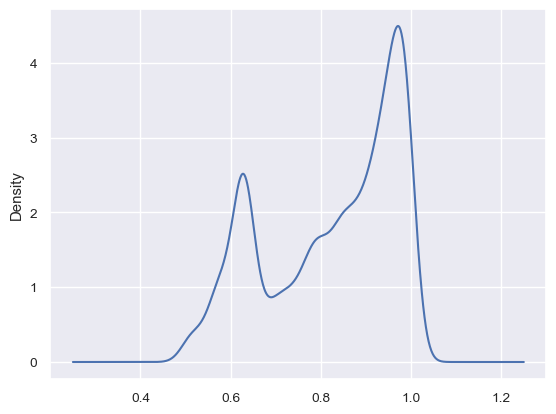

In [98]:
# Kernel Density Estimatation graph for pos sentiment
dataFrame[dataFrame.label=="pos"].compound.plot.kde();

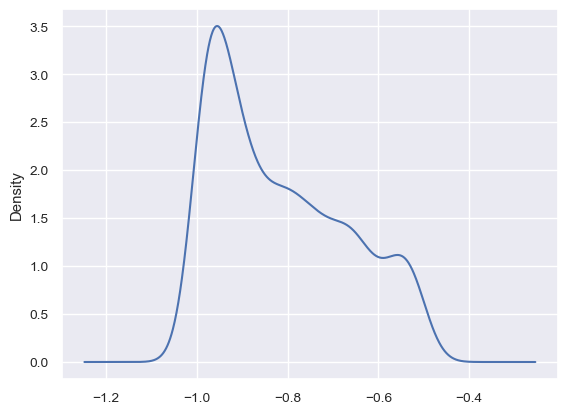

In [99]:
# Kernel Density Estimatation graph for neg sentiment
dataFrame[dataFrame.label=="neg"].compound.plot.kde();

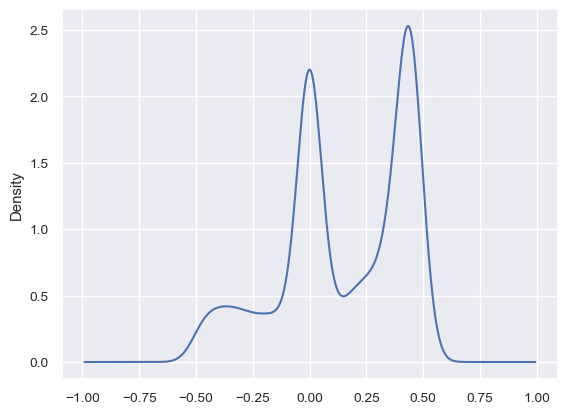

In [100]:
# Kernel Density Estimatation graph for neu sentiment
dataFrame[dataFrame.label=="neu"].compound.plot.kde();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


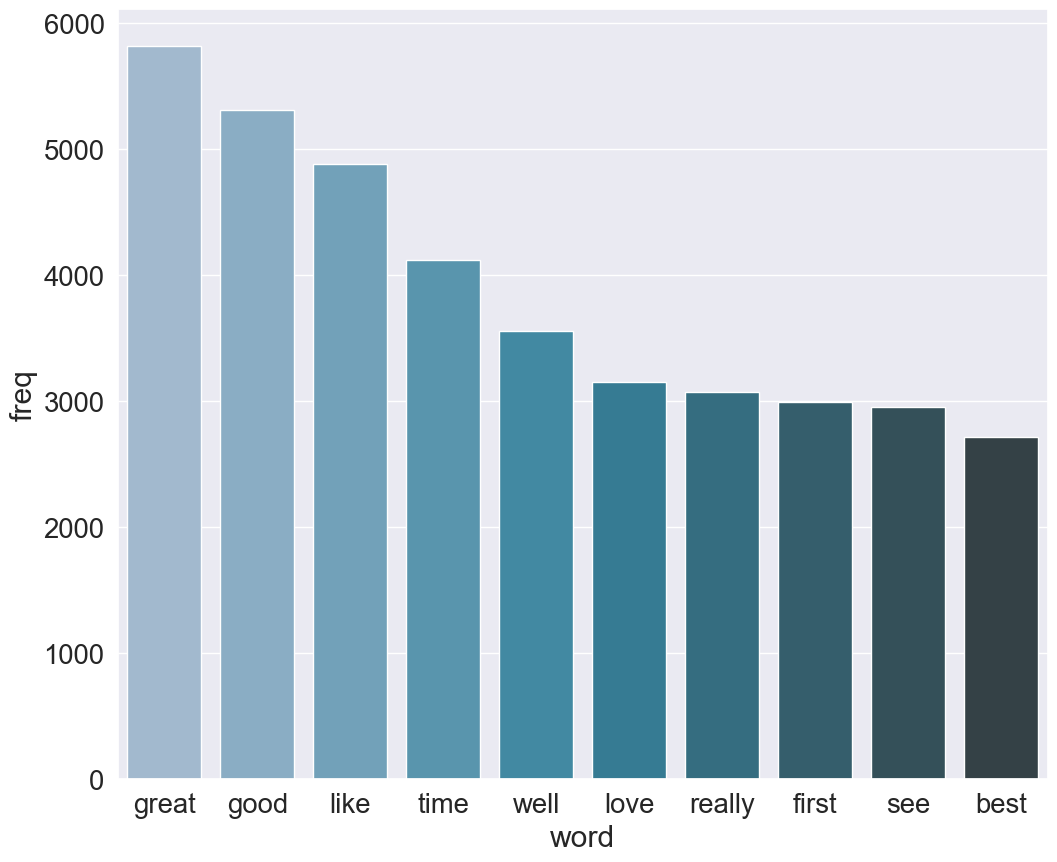

In [119]:
# Most frequent words in all reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(review)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [120]:
# Get positive, negative, and neutral reviews separately 
pos_reviews = pos['review']
neg_reviews = neg['review']
neu_reviews = neu['review']

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


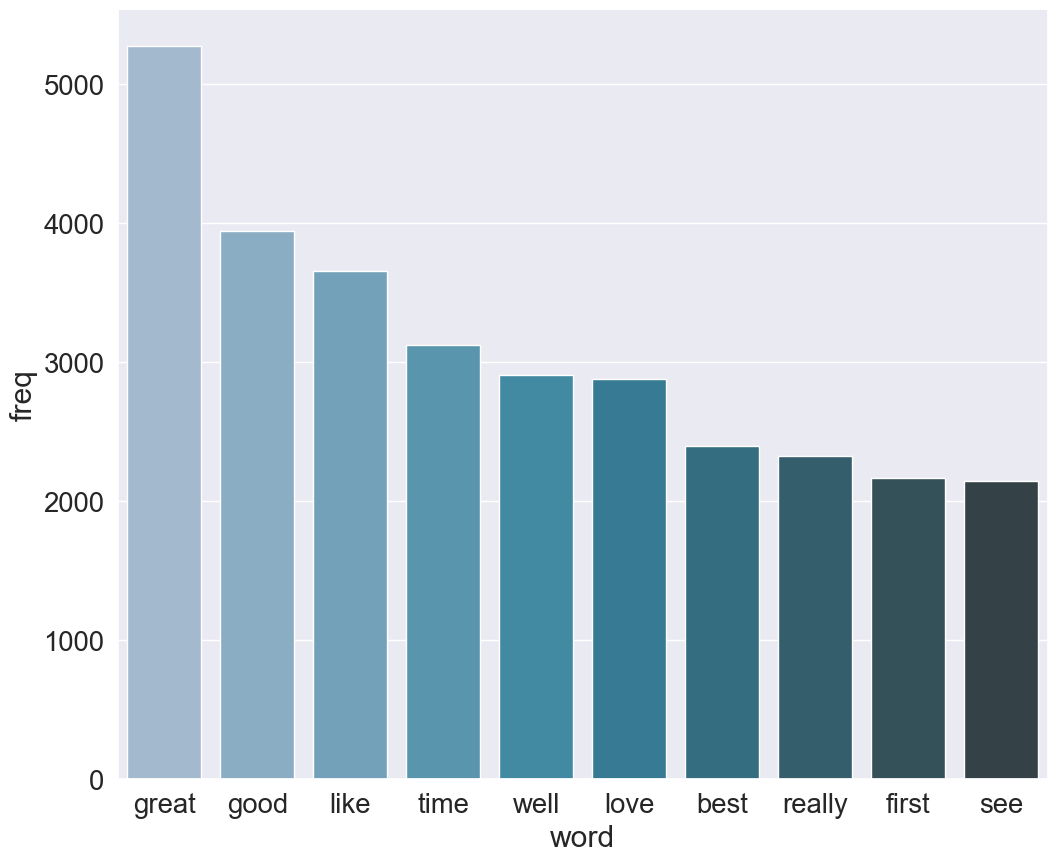

In [121]:
# Most frequent words in pos reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(pos_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


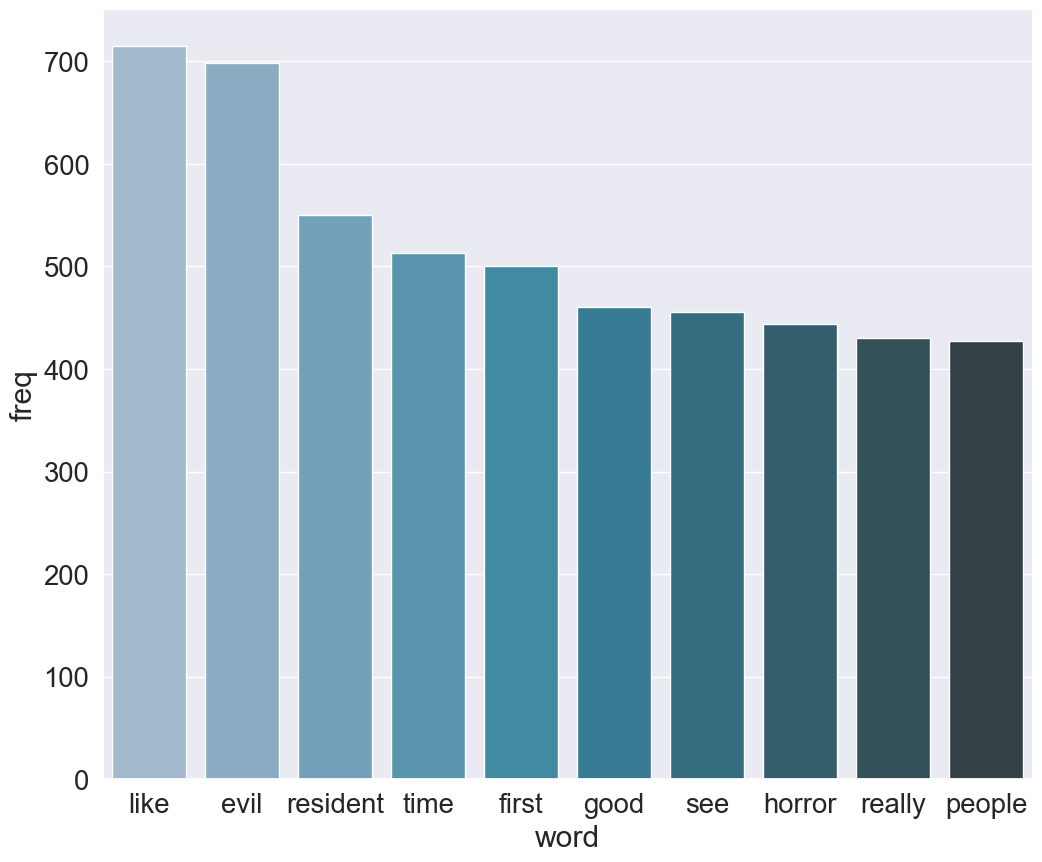

In [122]:
# Most frequent words in neg reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(neg_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


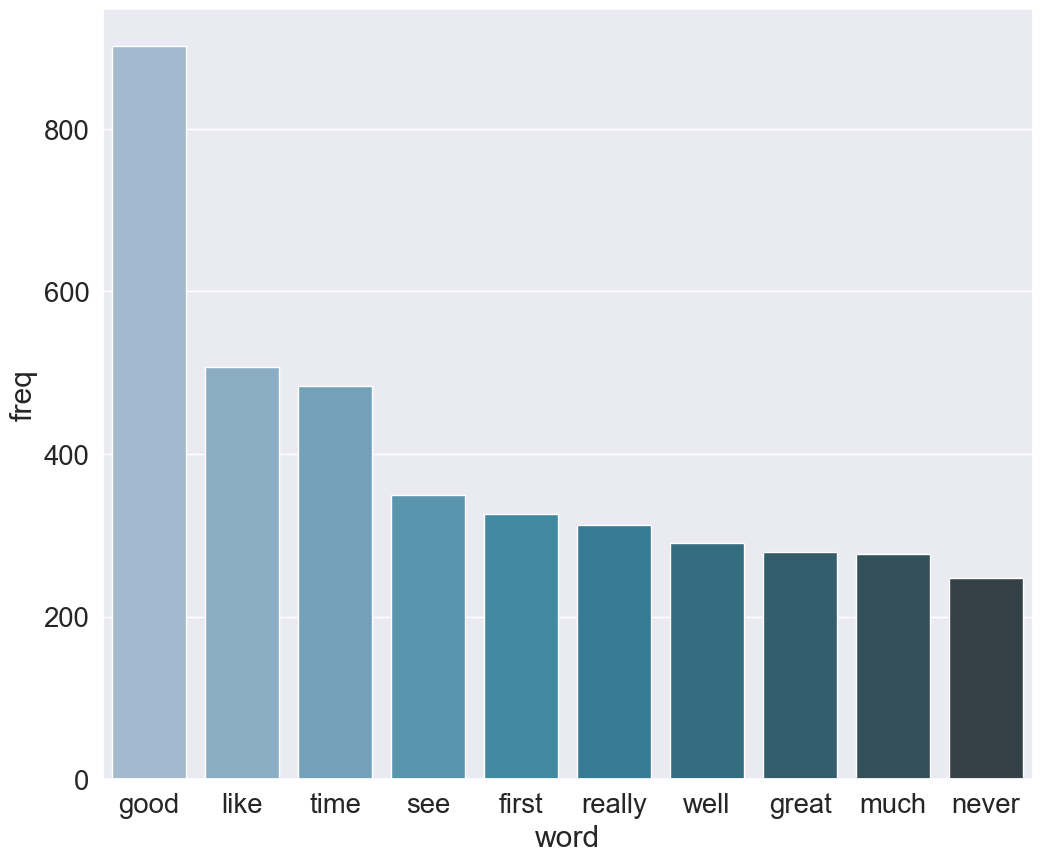

In [123]:
# Most frequent words in neu reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(neu_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [106]:
# Find reviews where neutral score is higher than positive or negative
compare_reviews = dataFrame.where((dataFrame['neu'] > dataFrame['pos']) & (
    dataFrame['neu'] > dataFrame['neg']))


compare_reviews = compare_reviews[~compare_reviews['label'].isnull()]


compare_reviews.head(10)

,neg,neu,pos,compound,review,label
0,0.039,0.537,0.424,0.9312,sorry n't purchase ago first came good enterta...,pos
1,0.000,0.631,0.369,0.8221,believe tell receive blessing watching video c...,pos
2,0.000,0.647,0.353,0.8540,seen live times early days recent reunion show...,pos
3,0.019,0.554,0.427,0.9902,excited finally live concert video 've seen tw...,pos
4,0.037,0.740,0.223,0.9920,best punk bands ever n't like calling punk ban...,pos
5,0.058,0.511,0.432,0.9952,'ve loved since first saw san francisco believ...,pos
6,0.081,0.540,0.380,0.9696,must admit hesitant purchase punk band perform...,pos
10,0.000,1.000,0.000,0.0000,learn ended state dying country,neu
14,0.000,1.000,0.000,0.0000,must read,neu
15,0.000,0.562,0.438,0.4404,well done video important information american...,neu


In [109]:
# Obtain lists of pos, neg, and neu words in one of the sentences 
pos_words = []
neg_words =[]
neu_words =[]

review_text = dataFrame.iloc[0]["review"]

words = nltk.word_tokenize(review_text)

for word in words:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_words.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_words.append(word)
    else:
        neu_words.append(word)  

print(review_text)
print('Positive ->',pos_words)        
print('Neutral ->:',neu_words)    
print('Negative ->',neg_words)  

sorry n't purchase ago first came good entertaining absolutely loved anticipate seeing repeatedly actually wore cassette purchased product best purchase made purchase find
Positive -> ['loved', 'best']
Neutral ->: ['sorry', "n't", 'purchase', 'ago', 'first', 'came', 'good', 'entertaining', 'absolutely', 'anticipate', 'seeing', 'repeatedly', 'actually', 'wore', 'cassette', 'purchased', 'product', 'purchase', 'made', 'purchase', 'find']
Negative -> []


In [110]:
count = len(pos_words) + len(neg_words) + len(neu_words)
count

23

In [111]:
pos_perc = len(pos_words)/count
print("% of positive words is ", round(pos_perc,2))

% of positive words is  0.09


In [112]:
neg_perc = len(neg_words)/count
print("% of negative words is ", round(neg_perc,2))

% of negative words is  0.0


In [113]:
neu_perc = len(neu_words)/count
print("% of neutral words is ", round(neu_perc,2))

% of neutral words is  0.91
